In [1]:
import json
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

from QAckis.Logfiles.Logfile import Logfile

motion_management_result_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/MotionManagement'
patient_data_root = r'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
patient_data_archive_root = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Patient_Data_Archive'
logfile_path = '/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles'
logfile_path_archive = f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles_archive'


In [2]:
def read_report(filename):
    with open(filename, 'r') as file:
        report = json.load(file)
    return report

def find_start_index(cine_times, treatment_time):
    """
    Find the index in cine_times where the treatment time starts.
    if cine times are longer than treatment times, assume that the treatment is during the end of the cines.
    param cine_times: The list of cine times.
    param treatment_time: The treatment time.
    returns: The index where the treatment time starts.
    """
    if np.max(cine_times) > treatment_time:
        time_discard = np.max(cine_times) - treatment_time
        transversal_start_index = np.argmax(cine_times >= time_discard) 
    else:
        transversal_start_index = 0 
    
    return transversal_start_index

def displacement_statistics_1d(cine_times:np.array, translations:np.array, treatment_time:float, q:float=0.975) -> np.array:

    start_index = find_start_index(cine_times, treatment_time)
    translations_reset = translations[start_index:]
    translations_reset = translations_reset - np.mean(translations_reset[0:10])

    qq = 100*q
    return[np.percentile(translations_reset, qq), np.percentile(translations_reset, 100-qq)] 

def displacement_statistics(report, treatment_time:float, q:float=0.975) -> list:
    """
    Calculate the displacement statistics from the report.
    param report: The report containing displacement data.
    param treatment_time: The treatment time to consider.
    param q: The quantile to calculate (default is 0.975).
    returns: A list containing the quantile and its complement for each displacement type.
    """
    return [displacement_statistics_1d(report['TimesTransversal'] , report['DisplacementTransversalX'], treatment_time, q),
            displacement_statistics_1d(report['TimesCoronal'], report['DisplacementCoronalX'], treatment_time, q),
            displacement_statistics_1d(report['TimesTransversal'], report['DisplacementTransversalY'], treatment_time, q),
            displacement_statistics_1d(report['TimesSagittal'], report['DisplacementSagittalY'], treatment_time, q),
            displacement_statistics_1d(report['TimesSagittal'], report['DisplacementSagittalZ'], treatment_time, q),
            displacement_statistics_1d(report['TimesCoronal'], report['DisplacementCoronalZ'], treatment_time, q)]
 
def read_logfile(filename) -> Logfile|None:
    
    logfile = None
    filenames = glob.glob(os.path.join(logfile_path, os.path.basename(filename)))
    #if len(filenames) == 0:
    #    filenames = glob.glob(os.path.join(logfile_path_archive, '*', os.path.basename(filename))) 
    
    if len(filenames) == 0:
        return None

    logfile = Logfile.from_csv(filenames[0])
    return logfile

def has_logfile_terminated_fault(logfile:Logfile) -> bool:
    """
    Check if the logfile has been terminated properly.
    """
    indices_terminated_fault = np.argwhere(logfile.linac_states == b'Terminated Fault')
    if len(indices_terminated_fault) == 0:
        return False
    return True

def xx_filenames(patient, fraction, pattern='RP*.dcm'):
    filenames = glob.glob(os.path.join(patient_data_root, patient, fraction, pattern))
    if len(filenames) == 0:
        filenames = glob.glob(os.path.join(patient_data_archive_root, patient, fraction, pattern)) 
    return filenames


def read_treatment_info(patient_ID, plan_label):
    filenames = xx_filenames(patient_ID, plan_label, '*logfile.txt')
    
    date = None
    treatment_time = None

    if len(filenames) == 0:
        return None, None

    with open(filenames[0] , 'r') as file:
        logfile_report = json.load(file)
        date = datetime.datetime.strptime(logfile_report['rtplan_datetime'][:-6], '%Y-%m-%d %H:%M:%S').date()
        
        logfile = read_logfile(logfile_report['log_filename'])
        
        if logfile is not None:
            if has_logfile_terminated_fault(logfile):
                return date, None

            treatment_time = np.max(logfile.times)
        
    return date, treatment_time 

filenames = glob.glob(os.path.join(motion_management_result_path, '*.json'))
reports = [read_report(filename) for filename in filenames]
reports = {(report['PatientID'], report['PlanLabel']): report for report in reports}  

In [42]:
for k, v in reports.items():
    print(v['PatientID'], v['PlanLabel'])
    break

import pydicom
filenames = glob.glob(os.path.join(patient_data_root, '193211030873', '10MRL1ADT01', 'RD*.dcm'))
pydicom.read_file(filenames[0])

193211030873 10MRL1ADT01


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.114337.1.1.1747126290.2
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.6
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_366'
(0002, 0016) Source Application Entity Title     AE: 'CMS_SCU'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: RT Dose Storage
(0008, 0018) SOP Instance UID                    UI: 2.16.840.1.114337.1.1.1747126290.2
(0008, 0020) Study Date                          DA: '20250513'
(0008, 0030) Study Time                 

## Read all reports and logfiles.
Save dictionary to json for later

In [ ]:


treatment_info = {} 
for key, value in reports.items():
    patient_ID, plan_label = key
    date, treatment_time = read_treatment_info(patient_ID,plan_label)
    treatment_info[(patient_ID, plan_label)] = (date, treatment_time)

#
# Filter all treatments that did not have a logfile (< PRIOR TO 2023)
#
print(len(treatment_info))
treatment_info = { key : value for key, value in treatment_info.items() if value[0] is not None} 
print(len(treatment_info))
treatment_info = { key : value for key, value in treatment_info.items() if value[1] is not None} 


# dump to result, convert tuple keys and values to strings since json cannot handle tuples
def foo(value):
    return f"('{value[0].strftime('%Y-%m-%d')}','{str(value[1])}')" 
treatment_info_str = {str(key): foo(value) for key, value in treatment_info.items()}
json.dump(treatment_info_str, open('treatment_info.json', 'w'), indent=4, sort_keys=True)



logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_13 09_00_11 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_15 08_38_59 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_21 09_52_46 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_22 08_57_43 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_26 08_52_37 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/25_05_28 07_45_52 Z 1_F218.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/Logfiles/24_11_12 10_08_09 Z 1_F219.csv
logfile read data columns end
logfile read data columns start/mnt/P/TERAPI/MRLINAC/QA

## Filter out reports of interest 
- After 2024-10-01
- Logfile must exist (if treatment was aborted then not there)
- Motion trace should be 90% the length of the treatment time

In [3]:
from ast import literal_eval
#
# Read treatment info and convert to tuples from strings and then to datetime and floats 
#
treatment_info_str = json.load(open('treatment_info.json','r'))
treatment_info = {literal_eval(key): literal_eval(value) for key, value in treatment_info_str.items()} 
print(len(treatment_info))

def foo(value):
    return (datetime.datetime.strptime(value[0], '%Y-%m-%d').date(), float(value[1]))
treatment_info = {key: foo(value) for key, value in treatment_info.items()} 
print(len(treatment_info))

#
# Filter all treatments before 2024-10-01 
#
treatment_info = { key: value for key, value in treatment_info.items() if value[0] >= datetime.date(2024, 10, 1)} 
print(len(treatment_info))

#
# Filter out motion traces signinifcantly short than treatment times
#
#treatment_info = { key: value for key, value in treatment_info.items() if value[1] > 400} 
#print(len(treatment_info))
for key, value in treatment_info.items():
    patient_ID, plan_label = key
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Will remove {key} with cine time {cine_time} and treatment time {treatment_time}")
        

def not_short_cine_times(key, value, reports):
    """
    Remove entries from treatment_info where the cine time is significantly shorter than the treatment time.
    """
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Remooooooving {key} with cine time {cine_time} and treatment time {treatment_time}")
        return False
    return True

print(len(treatment_info), 'sdfsdf')    
treatment_info = { key:value for key,value in treatment_info.items() if not_short_cine_times(key, value, reports)}

print(len(treatment_info), 'sdfsdf')
for key, value in treatment_info.items():
    treatment_time = value[1]
    cine_time = np.max(reports[key]['TimesTransversal'])
    if cine_time < (treatment_time * 0.9):
        print(f"Removing {key} with cine time {cine_time} and treatment time {treatment_time}")
        not_short_cine_times(key, value, reports)



# dump to result, convert tuple keys and values to strings since json cannot handle tuples
def foo(value):
    return f"('{value[0].strftime('%Y-%m-%d')}','{str(value[1])}')" 
treatment_info_str = {str(key): foo(value) for key, value in treatment_info.items()}
json.dump(treatment_info_str, open('treatment_info_late.json', 'w'), indent=4, sort_keys=True)


465
465
195
Will remove ('194202130656', '12MRL1ADT05') with cine time 439 and treatment time 534.64
Will remove ('194605187592', '10MRL1ADT07') with cine time 287 and treatment time 374.68
195 sdfsdf
Remooooooving ('194202130656', '12MRL1ADT05') with cine time 439 and treatment time 534.64
Remooooooving ('194605187592', '10MRL1ADT07') with cine time 287 and treatment time 374.68
193 sdfsdf


## Extract motion statistics for the remaining traces
If motion trace longer than treatment time, assume that the irradiation is at the end

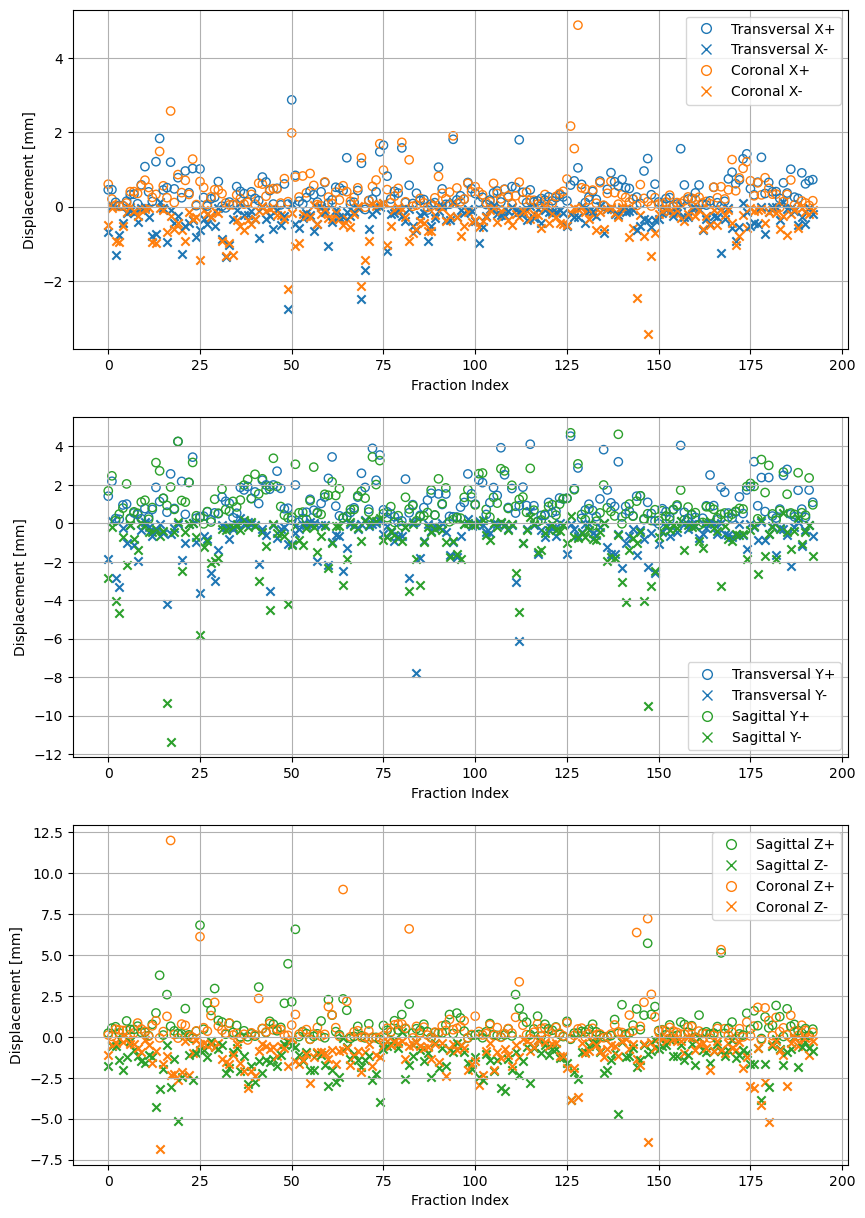

In [4]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

dxp, dyp, dzp = [], [], []
dxm, dym, dzm = [], [], []

for index, (key, value) in enumerate(treatment_info.items()):
    patient_ID, plan_label = key
    report = reports[key]
    treatment_time = float(value[1])
    displacement_stats = displacement_statistics(report, treatment_time, q=0.975)
    [[txp, txm], [cxp, cxm], [typ, tym], [syp, sym], [szp, szm], [czp, czm]] = displacement_stats
    
    #dxp.append(np.mean([txp, cxp]))
    #dyp.append(np.mean([typ, syp]))
    #dzp.append(np.mean([szp, czp]))    
    #dxm.append(np.mean([txm, cxm]))
    #dym.append(np.mean([tym, sym]))
    #dzm.append(np.mean([szm, czm]))

    dxp.append(np.max([txp, cxp]))
    dyp.append(np.max([typ, syp]))
    dzp.append(np.max([szp, czp]))    
    dxm.append(np.min([txm, cxm]))
    dym.append(np.min([tym, sym]))
    dzm.append(np.min([szm, czm]))

    ax1.scatter(index, txp, color='C0', facecolors='none', label='Transversal X+')
    ax1.scatter(index, txm, marker='x', color='C0', label='Transversal X-')
    ax1.scatter(index, cxp, color='C1', facecolors='none', label='Coronal X+')
    ax1.scatter(index, cxm, marker='x', color='C1', label='Coronal X-')
    ax2.scatter(index, typ, color='C0', facecolors='none', label='Transversal Y+')
    ax2.scatter(index, tym, marker='x', color='C0', label='Transversal Y-')
    ax2.scatter(index, syp, color='C2', facecolors='none', label='Sagittal Y+') 
    ax2.scatter(index, sym, marker='x', color='C2', label='Sagittal Y-') 
    ax3.scatter(index, szp, color='C2', facecolors='none', label='Sagittal Z+')
    ax3.scatter(index, szm, marker='x', color='C2', label='Sagittal Z-')
    ax3.scatter(index, czp, color='C1', facecolors='none', label='Coronal Z+')
    ax3.scatter(index, czm, marker='x', color='C1', label='Coronal Z-')

for ax in[ax1, ax2, ax3]:
    ax.set_xlabel('Fraction Index')
    ax.set_ylabel('Displacement [mm]')
    ax.grid()
    #ax.legend()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_x = [Line2D([0], [0], marker='o', color='none', label='Transversal X+', markerfacecolor=None, markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Transversal X-', markerfacecolor='C0', markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Coronal X+', markerfacecolor=None, markeredgecolor='C1', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Coronal X-', markerfacecolor='C1', markeredgecolor='C1', markersize=7)]

ax1.legend(handles=legend_x)

legend_y = [Line2D([0], [0], marker='o', color='none', label='Transversal Y+', markerfacecolor=None, markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Transversal Y-', markerfacecolor='C0', markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Sagittal Y+', markerfacecolor=None, markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Sagittal Y-', markerfacecolor='C2', markeredgecolor='C2', markersize=7)]
ax2.legend(handles=legend_y)

legend_z = [Line2D([0], [0], marker='o', color='none', label='Sagittal Z+', markerfacecolor=None, markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Sagittal Z-', markerfacecolor='C2', markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Coronal Z+', markerfacecolor=None, markeredgecolor='C1', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Coronal Z-', markerfacecolor='C1', markeredgecolor='C1', markersize=7)]
ax3.legend(handles=legend_z)

## Find ouliers for later manual check

In [14]:
for index, (key, value) in enumerate(treatment_info.items()):
    patient_ID, plan_label = key
    report = reports[key]
    treatment_time = float(value[1])
    displacement_stats = displacement_statistics(report, treatment_time, q=0.975)
    [[txp, txm], [cxp, cxm], [typ, tym], [syp, sym], [szp, szm], [czp, czm]] = displacement_stats

    if txp > 5:
        print(patient_ID, plan_label, 'txp', txp)
    if txm > 5:
        print(patient_ID, plan_label, 'txm', txm)
    if cxp > 5:
        print(patient_ID, plan_label, 'cxp', cxp)
    if cxm > 5:
        print(patient_ID, plan_label, 'cxm', cxm)
    if typ > 5:
        print(patient_ID, plan_label, 'typ', typ)
    if tym > 5:
        print(patient_ID, plan_label, 'tym', tym)
    if syp > 5:
        print(patient_ID, plan_label, 'syp', syp)
    if sym > 5:
        print(patient_ID, plan_label, 'sym', sym)
    if szp > 5:
        print(patient_ID, plan_label, 'szp', szp)
    if szm > 5:
        print(patient_ID, plan_label, 'szm', szm)
    if czp > 5:
        print(patient_ID, plan_label, 'czp', czp)
    if czm > 5:
        print(patient_ID, plan_label, 'czm', czm)


194205201496 10MRL1ADT07 czp 12.011142460000002
194409238252 10MRL1ADT01 szp 6.83008125
194409238252 10MRL1ADT01 czp 6.127796
194509301232 12MRL1ADT06 szp 6.577266
194807111135 10MRL1ADT03 czp 9.0117455
195105066699 10MRL1ADT14 czp 6.603873000000001
195404092099 13MRL1ADT03 czp 6.380995199999996
195404092099 13MRL1ADT07 szp 5.72430725
195404092099 13MRL1ADT07 czp 7.232735
195812031671 10MRL1ADT12 szp 5.135133649999999
195812031671 10MRL1ADT12 czp 5.3341487800000005


## Plot results

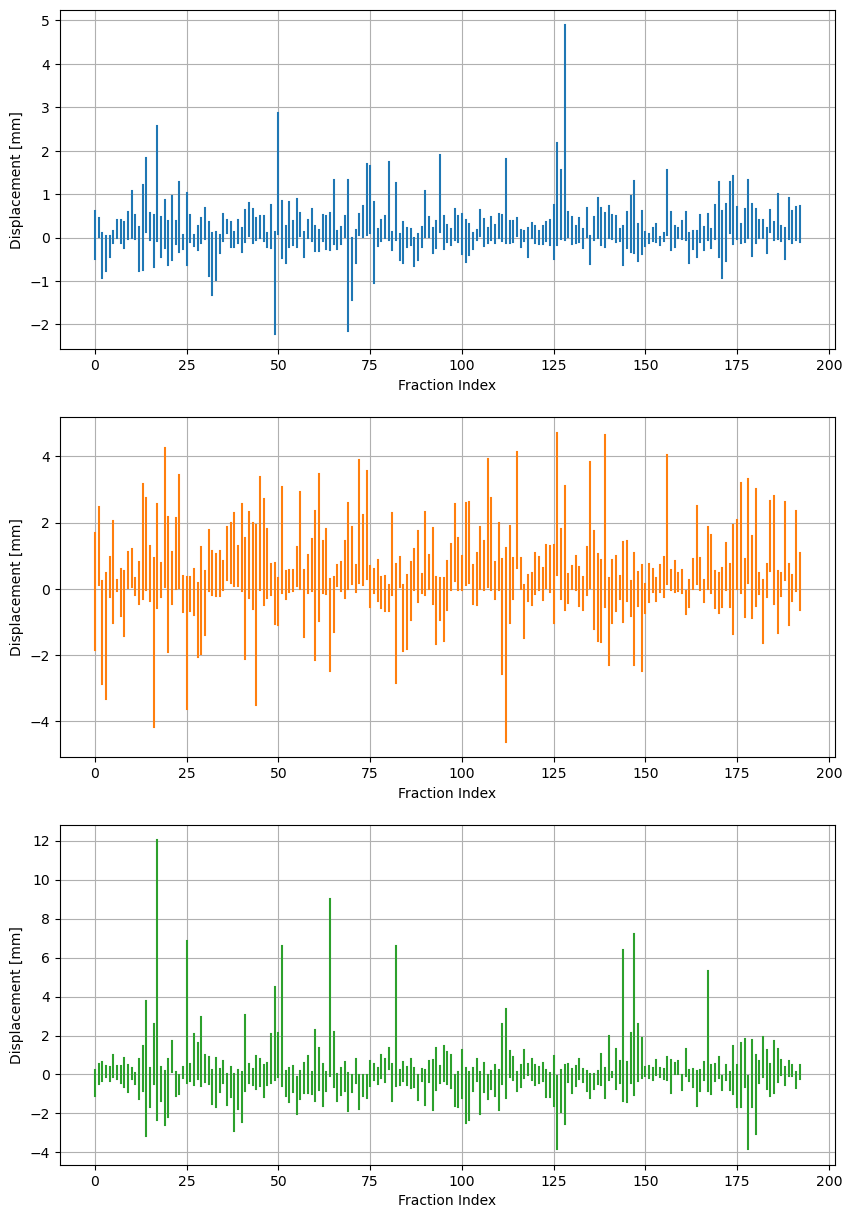

In [24]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

for i in range(len(dxp)):    
    ax1.plot([i, i], [dxm[i], dxp[i]], color='C0', label='X')
    ax2.plot([i, i], [dym[i], dyp[i]], color='C1', label='Y')
    ax3.plot([i, i], [dzm[i], dzp[i]], color='C2', label='Z')

for ax in[ax1, ax2, ax3]:
    ax.set_xlabel('Fraction Index')
    ax.set_ylabel('Displacement [mm]')
    ax.grid()
    #ax.legend()




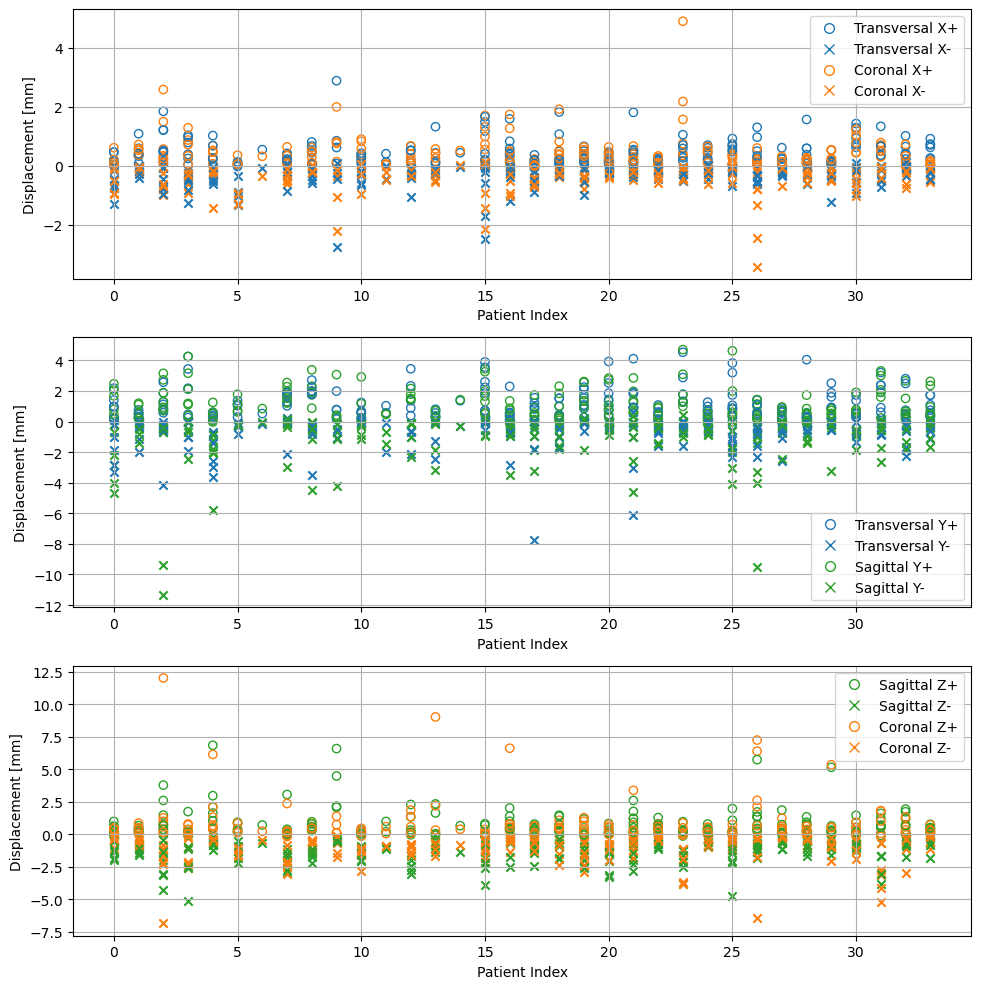

In [5]:
#
# plot per patient
#
patients = {}

for index, (key, value) in enumerate(treatment_info.items()):
    patient_ID, plan_label = key
    
    if patient_ID not in patients.keys():
        patients[patient_ID] = {}
    
    report = reports[key]
    treatment_time = float(value[1])
    displacement_stats = displacement_statistics(report, treatment_time, q=0.975)
    [[txp, txm], [cxp, cxm], [typ, tym], [syp, sym], [szp, szm], [czp, czm]] = displacement_stats

    patients[patient_ID][plan_label] = displacement_stats



f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

for patient_ID, plans in patients.items():

    patient_index = list(patients.keys()).index(patient_ID)
    for _, ds in plans.items():
        
        [[txp, txm], [cxp, cxm], [typ, tym], [syp, sym], [szp, szm], [czp, czm]] = ds
        ax1.scatter(patient_index, txp, marker='o', color='C0', facecolors='none')
        ax1.scatter(patient_index, txm, marker='x', color='C0')
        ax1.scatter(patient_index, cxp, marker='o', color='C1', facecolors='none')
        ax1.scatter(patient_index, cxm, marker='x', color='C1')
        ax2.scatter(patient_index, typ, marker='o', color='C0', facecolors='none')
        ax2.scatter(patient_index, tym, marker='x', color='C0')
        ax2.scatter(patient_index, syp, marker='o', color='C2', facecolors='none')
        ax2.scatter(patient_index, sym, marker='x', color='C2')
        ax3.scatter(patient_index, szp, marker='o', color='C2', facecolors='none')
        ax3.scatter(patient_index, szm, marker='x', color='C2')
        ax3.scatter(patient_index, czp, marker='o', color='C1', facecolors='none')
        ax3.scatter(patient_index, czm, marker='x', color='C1')

for ax in[ax1, ax2, ax3]:
    ax.set_xlabel('Patient Index')
    ax.set_ylabel('Displacement [mm]')
    ax.grid()

from matplotlib.lines import Line2D
legend_x = [Line2D([0], [0], marker='o', color='none', label='Transversal X+', markerfacecolor=None, markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Transversal X-', markerfacecolor='C0', markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Coronal X+', markerfacecolor=None, markeredgecolor='C1', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Coronal X-', markerfacecolor='C1', markeredgecolor='C1', markersize=7)]
ax1.legend(handles=legend_x)

legend_y = [Line2D([0], [0], marker='o', color='none', label='Transversal Y+', markerfacecolor=None, markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Transversal Y-', markerfacecolor='C0', markeredgecolor='C0', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Sagittal Y+', markerfacecolor=None, markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Sagittal Y-', markerfacecolor='C2', markeredgecolor='C2', markersize=7)]
ax2.legend(handles=legend_y)      

legend_z = [Line2D([0], [0], marker='o', color='none', label='Sagittal Z+', markerfacecolor=None, markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Sagittal Z-', markerfacecolor='C2', markeredgecolor='C2', markersize=7),
            Line2D([0], [0], marker='o', color='none', label='Coronal Z+', markerfacecolor=None, markeredgecolor='C1', markersize=7),
            Line2D([0], [0], marker='x', color='none', label='Coronal Z-', markerfacecolor='C1', markeredgecolor='C1', markersize=7)]
ax3.legend(handles=legend_z)

f.tight_layout()


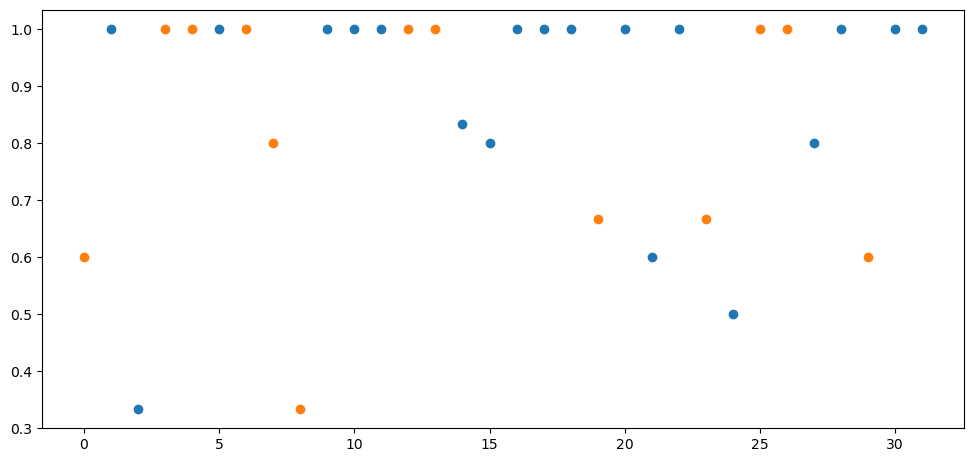

In [20]:
def within_criterion(ds, criterion=3.):
    """
    Check if the value is within the criterion.
    """
    return np.all(np.abs(ds) <= criterion)

#
# Probability of displacement given a small displacement in the first fraction
#
first_fx_within_criterion = {}
rest_fx_also_within_criterion = {}
f, ax = plt.subplots(figsize=(25/2.54, 12/2.54))

for index, (patient_ID, plans) in enumerate(patients.items()):

    if len(plans) < 2:
        continue

    plan_iter = iter(plans)

    # first fraction
    first_plan = plans[next(plan_iter)]
    first_fx_within_criterion[patient_ID] = within_criterion(first_plan, 2)
    
    rest_fx_also_within_criterion[patient_ID] = []
    while True:
        ds = next(plan_iter, False)
        if not ds:
            break
        rest_fx_also_within_criterion[patient_ID].append(within_criterion(plans[ds], 4))


for patient_ID, is_within in first_fx_within_criterion.items():
    prob_within = np.mean(rest_fx_also_within_criterion[patient_ID])
    patient_index = list(first_fx_within_criterion.keys()).index(patient_ID)
    color = 'C0' if is_within else 'C1'
    ax.scatter(patient_index, prob_within, marker='o', color=color, label='2nd -> fx within')


f.tight_layout()





0.5759605817655439 0.5625782920667173 1.6016415099999979
-0.4800042242906736 0.47396737134815364 -1.2905953597999997
1.3692469183816063 1.0289062662548016 3.4454442399999987
-1.1421466322896372 1.6727902693624073 -4.054379246
1.0110158407230567 1.5882136904857533 3.5267783719999914
-1.5304447846697928 1.1013748073123408 -3.466927389999999


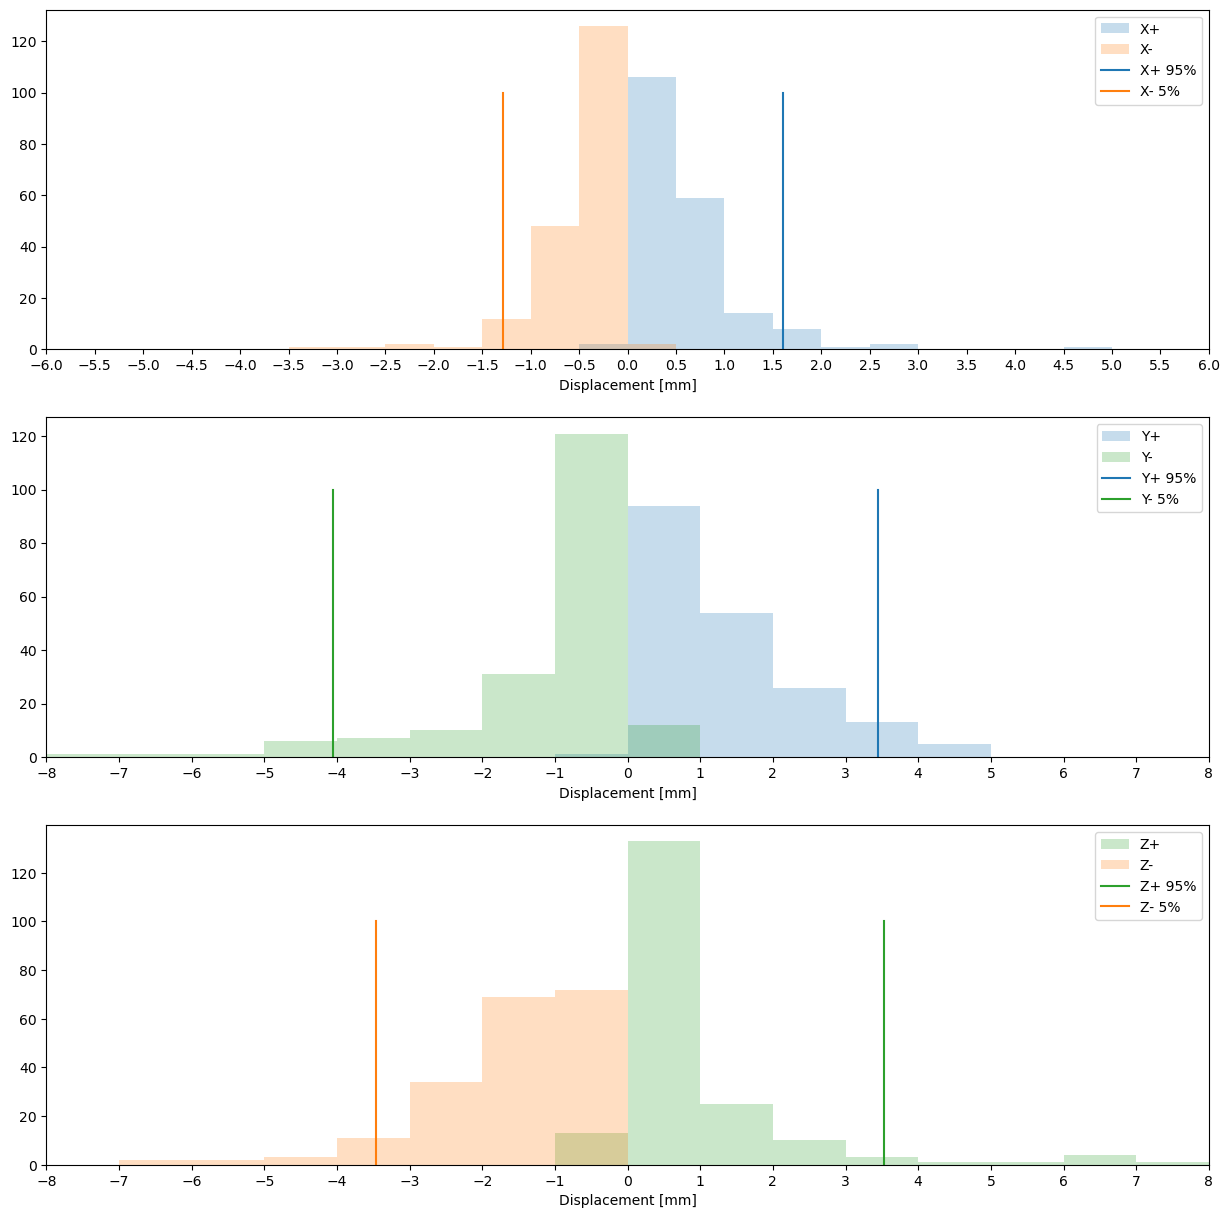

In [44]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

ax1.hist(dxp, range=[-6,6], bins=24, color='C0', alpha=0.25, label='X+')
ax1.hist(dxm, range=[-6,6], bins=24, color='C1', alpha=0.25, label='X-')

ax2.hist(dyp, range=[-12,12], bins=24, color='C0', alpha=0.25, label='Y+')
ax2.hist(dym, range=[-12,12], bins=24, color='C2', alpha=0.25, label='Y-')

ax3.hist(dzp, range=[-12,12], bins=24, color='C2', alpha=0.25, label='Z+')
ax3.hist(dzm, range=[-12,12], bins=24, color='C1', alpha=0.25, label='Z-')

ax1.plot([np.percentile(dxp, 95), np.percentile(dxp, 95)], [0., 100], color='C0', label='X+ 95%')
ax1.plot([np.percentile(dxm, 5), np.percentile(dxm, 5)], [0., 100], color='C1', label='X- 5%')

ax2.plot([np.percentile(dyp, 95), np.percentile(dyp, 95)], [0., 100], color='C0', label='Y+ 95%')
ax2.plot([np.percentile(dym, 5), np.percentile(dym, 5)], [0., 100], color='C2', label='Y- 5%')

ax3.plot([np.percentile(dzp, 95), np.percentile(dzp, 95)], [0., 100], color='C2', label='Z+ 95%')
ax3.plot([np.percentile(dzm, 5), np.percentile(dzm, 5)], [0., 100], color='C1', label='Z- 5%')

ax1.set_xlabel('Displacement [mm]')
ax2.set_xlabel('Displacement [mm]')
ax3.set_xlabel('Displacement [mm]')

print(np.mean(dxp), np.std(dxp), np.percentile(dxp, 95))
print(np.mean(dxm), np.std(dxm), np.percentile(dxm, 5))
print(np.mean(dyp), np.std(dyp), np.percentile(dyp, 95))
print(np.mean(dym), np.std(dym), np.percentile(dym, 5))
print(np.mean(dzp), np.std(dzp), np.percentile(dzp, 95))
print(np.mean(dzm), np.std(dzm), np.percentile(dzm, 5))

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_xlim([-6, 6])
ax1.set_xticks(np.arange(-6, 6.1, 0.5))

ax2.set_xlim([-8, 8])
ax2.set_xticks(np.arange(-8, 8.1, 1))
ax3.set_xlim([-8, 8])
ax3.set_xticks(np.arange(-8, 8.1, 1))


Time range: 24 - 37769 seconds
194904191451 10MRL1ADT02
treatment times mean 420.24688524590124 98.76284123589622
204


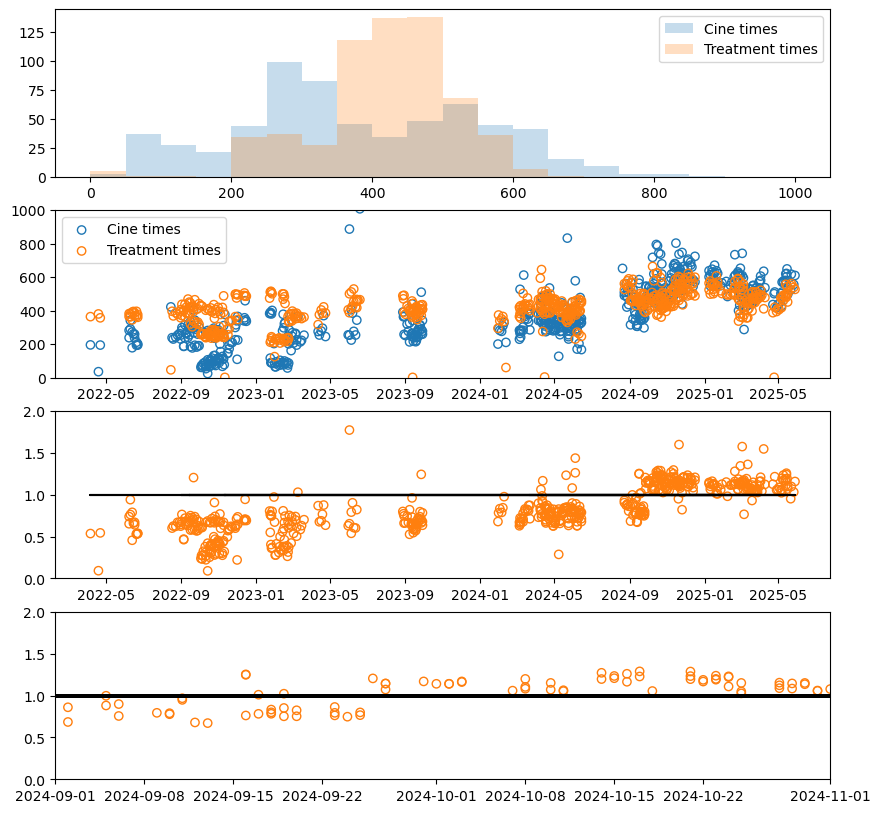

In [116]:
#
# Check the times
#
def time_check(report):
    return np.min([np.max(report['TimesTransversal']), np.max(report['TimesCoronal']), np.max(report['TimesSagittal'])])

def cine_relative_treatment_time(cine_times, treatment_times):
    """
    Calculate the relative cine times compared to the treatment times.
    """
    rel_ts = len(cine_times) * []
    for i in range(len(cine_times)):
        if treatment_times[i] is None or cine_times[i] is None:
            rel_ts.append(None)
        else:
            rel_ts.append(cine_times[i] / treatment_times[i])
    return rel_ts
    

cine_times = np.array([time_check(report) for report in reports])
treatment_times = np.array(times)
print(f'Time range: {np.min(cine_times)} - {np.max(cine_times)} seconds')
print(reports[np.argmax(cine_times)]['PatientID'], reports[np.argmax(cine_times)]['PlanLabel'])

print('treatment times mean',np.mean(treatment_times[treatment_times != None]), np.std(treatment_times[treatment_times != None]))

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

ax1.hist(cine_times[cine_times != None] , bins=20, range=[0, 1000], label='Cine times', alpha=0.25)
ax1.hist(treatment_times[treatment_times != None], bins=20, range=[0, 1000], label='Treatment times', alpha=0.25)

ax2.scatter(dates, cine_times, color='C0', facecolors='none', label='Cine times')
#ax2.set_ylim(0, 1000)

dates[0:20], cine_times[0:20] 
ax2.scatter(dates, treatment_times, color='C1', facecolors='none', label='Treatment times')
ax2.set_ylim(0, 1000)


ax3.scatter(dates, cine_relative_treatment_time(cine_times, treatment_times), color='C1', facecolors='none', label='Cine Times / Treatment times')
ax3.plot(dates, [1]*len(dates), color='black')
ax3.set_ylim(0, 2)

ax4.scatter(dates, cine_relative_treatment_time(cine_times, treatment_times), color='C1', facecolors='none', label='Cine Times / Treatment times')
ax4.plot(dates, [1]*len(dates), color='black')
ax4.set_ylim(0, 2)
ax4.set_xlim(datetime.date(2024, 9, 1), datetime.date(2024, 11, 1))

filtered_dates = [date for date in dates if date != None]
filtered_dates = [date for date in filtered_dates if date > datetime.date(2024, 10, 1)]
print(len(filtered_dates))

ax1.legend()
ax2.legend()

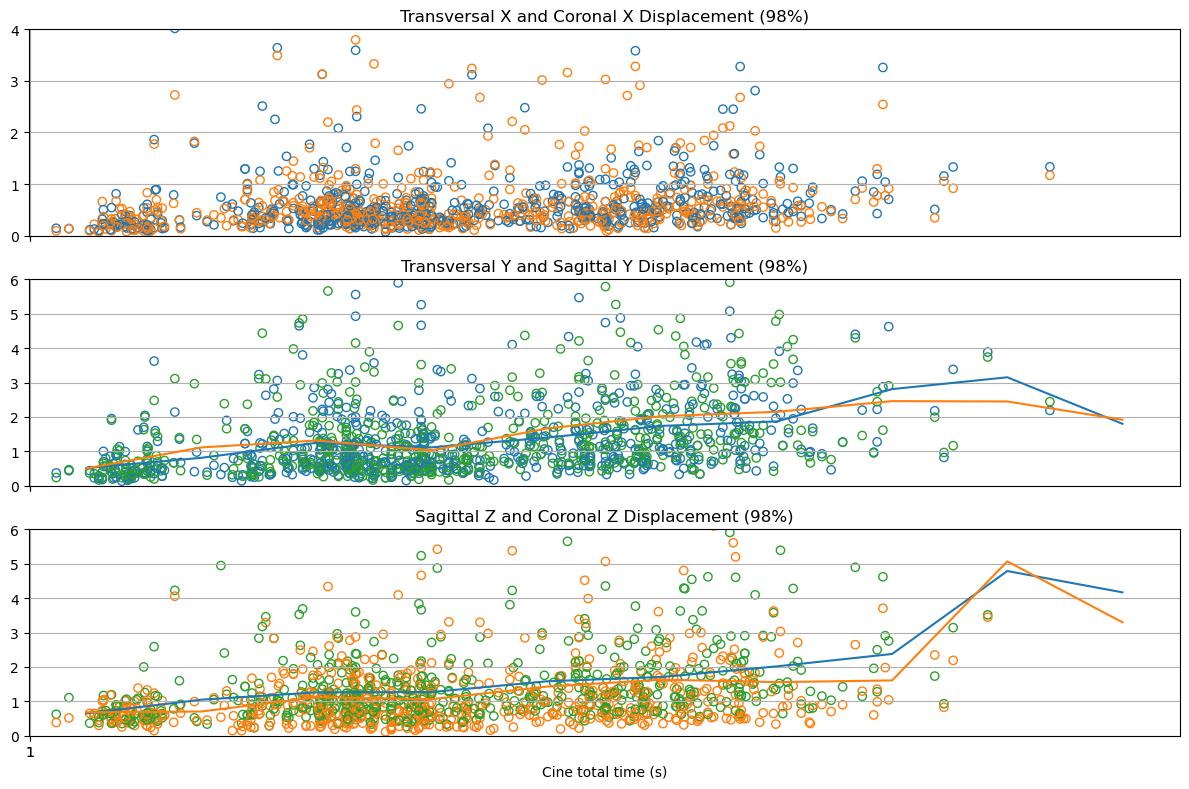

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 8))

txs = np.zeros(len(filenames))
cxs = np.zeros(len(filenames))
tys = np.zeros(len(filenames))
sys = np.zeros(len(filenames))
szs = np.zeros(len(filenames))
czs = np.zeros(len(filenames))

txs_range = [[] for i in range(10)] 
cxs_range = [[] for i in range(10)] 
tys_range = [[] for i in range(10)] 
sys_range = [[] for i in range(10)] 
szs_range = [[] for i in range(10)] 
czs_range = [[] for i in range(10)] 

def sort_in_time_range(cine_time):
    return min(9, cine_time // 100)

for i, report in enumerate(reports):
    txs[i], cxs[i], tys[i], sys[i], szs[i], czs[i] = displacement_statistics(reports[i])
    r = sort_in_time_range(cine_times[i])
    try:
        #txs_range[r].append(txs[i])
        txs_range[r].append(txs[i])
        cxs_range[r].append(cxs[i])
        tys_range[r].append(tys[i])
        sys_range[r].append(sys[i])
        szs_range[r].append(szs[i])
        czs_range[r].append(czs[i])
    except IndexError:
        print(f'IndexError for {i} with cine time {cine_times[i]} and range {r}')


for i in range(len(filenames)):
    
    #ax1.scatter(cine_times[i], txs[i], color='C0', facecolors='none')
    #ax1.scatter(cine_times[i], cxs[i], color='C1', facecolors='none')

    ax2.scatter(cine_times[i], tys[i], color='C0', facecolors='none')
    ax2.scatter(cine_times[i], sys[i], color='C2', facecolors='none')

    ax3.scatter(cine_times[i], szs[i], color='C2', facecolors='none')
    ax3.scatter(cine_times[i], czs[i], color='C1', facecolors='none')

ax1.boxplot(np.arange(0, 1000, 100) + 50, [txs_range[i] for i in range(10)])
ax1.boxplot(np.arange(0, 1000, 100) + 50, [cxs_range[i] for i in range(10)])
 
#ax1.plot(np.arange(0, 1000, 100) + 50, [np.mean(txs_range[i]) for i in range(10)])
#ax1.plot(np.arange(0, 1000, 100) + 50, [np.mean(cxs_range[i]) for i in range(10)])
ax2.plot(np.arange(0, 1000, 100) + 50, [np.mean(tys_range[i]) for i in range(10)])
ax2.plot(np.arange(0, 1000, 100) + 50, [np.mean(sys_range[i]) for i in range(10)])
ax3.plot(np.arange(0, 1000, 100) + 50, [np.mean(szs_range[i]) for i in range(10)])
ax3.plot(np.arange(0, 1000, 100) + 50, [np.mean(czs_range[i]) for i in range(10)]) 

ax1.set_title('Transversal X and Coronal X Displacement (98%)')
ax2.set_title('Transversal Y and Sagittal Y Displacement (98%)')
ax3.set_title('Sagittal Z and Coronal Z Displacement (98%)')
ax3.set_xlabel('Cine total time (s)')

for ax in (ax1, ax2, ax3):
    ax.grid()
    ax.set_xlim(0, 1000)

ax1.set_ylim(0, 4)
ax2.set_ylim(0, 6)
ax3.set_ylim(0, 6)

f.tight_layout()

In [105]:
txs_range

[[0.20754696875,
  0.38774617500000014,
  0.20763456000000002,
  0.32296990500000006,
  0.31745023749999995,
  0.19193417000000002,
  0.15450988500000015,
  0.211488875,
  0.225621177,
  0.16556594250000004,
  0.126601538,
  0.221547425,
  0.2042124195000001,
  0.378307735,
  0.2667939375,
  0.12667935,
  0.21305190124999998,
  0.2708696519999999,
  0.13225029119999993,
  0.8110788499999999,
  0.500680815,
  0.40571708999999995,
  0.17751629480000006,
  0.25469386999999993,
  0.21117979999999997,
  0.5424783300000001,
  0.23128888875000006,
  0.19459416749999994,
  0.10488229,
  0.09867470749999997,
  0.09728521,
  0.11811050200000008,
  0.14779395624999997,
  0.10694344199999999,
  0.11057916250000004,
  0.14191162129999996,
  0.22612590624999998,
  0.15277459624999984,
  0.12923626600000004],
 [0.291784125,
  0.4513028569999998,
  0.1430300375,
  0.22955319799999999,
  0.18671741680000004,
  0.6111433000000001,
  0.20958570749999997,
  0.47222140499999965,
  0.8904971899999999,
  1.0